<a href="https://colab.research.google.com/github/Katakon17/utsPemMes2025/blob/main/Uts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. LIBRARY IMPORTS
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
!pip install annoy
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551810 sha256=41172d9c7a6071380f4e0847f6ee06bc507e68e19d5dbacb979c9d0b631c3ef1
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy
Libraries imported successfully!


In [ ]:
!pip install annoy

In [ ]:
df = pd.read_csv('/content/credit.csv')
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
print("Dataset Information:")
print("\nMissing Values per Column:")
print(df.isnull().sum())

Dataset Information:

Missing Values per Column:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [ ]:
# Create new feature: Average Bill Amount
print("\n=== CREATING NEW FEATURES ===")
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
df['AVG_BILL_AMT'] = df[bill_columns].mean(axis=1)

# Create another feature: Total Payment Amount
pay_amt_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df['TOTAL_PAY_AMT'] = df[pay_amt_columns].sum(axis=1)

df['UTILIZATION_RATIO'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1)


=== CREATING NEW FEATURES ===


In [ ]:
features_for_clustering = [
    'LIMIT_BAL', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'AVG_BILL_AMT', 'TOTAL_PAY_AMT', 'UTILIZATION_RATIO'
]

X = df[features_for_clustering]

In [ ]:
print("\n=== DATA NORMALIZATION ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Data normalized. Shape: {X_scaled.shape}")


=== DATA NORMALIZATION ===
Data normalized. Shape: (30000, 23)


=== KMEANS CLUSTERING ===


Text(0.5, 1.0, 'Elbow Method for Optimal k')

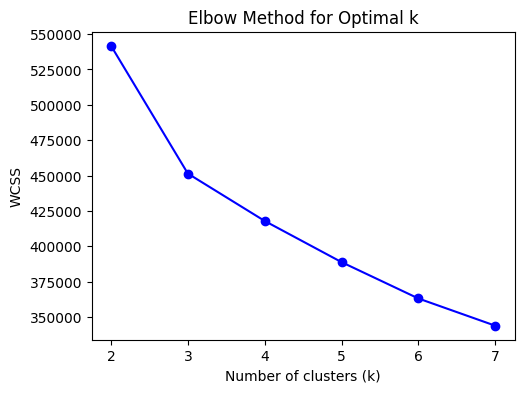

In [ ]:
# 4. CLUSTERING - KMEANS
print("=== KMEANS CLUSTERING ===")
# Determine optimal k using elbow method
wcss = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')

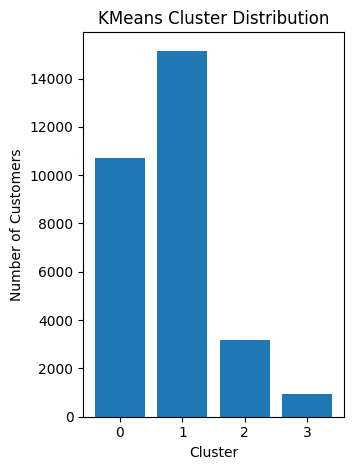

KMeans clustering completed with 4 clusters
Cluster distribution: [10702 15156  3183   959]


In [ ]:
# Apply KMeans with optimal k (let's choose 4 based on typical credit card segmentation)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['KMeans_Cluster'] = labels_kmeans

plt.subplot(1, 2, 2)
cluster_counts = pd.Series(labels_kmeans).value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('KMeans Cluster Distribution')
plt.tight_layout()
plt.show()

print(f"KMeans clustering completed with {len(np.unique(labels_kmeans))} clusters")
print(f"Cluster distribution: {np.bincount(labels_kmeans)}")

=== DBSCAN CLUSTERING ===
DBSCAN clustering completed
Number of clusters: 82
Number of noise points: 14376
Cluster distribution: [14376  7475   237   315    58   625  1449   276    37   186  1593   380
    23    33    68    73    93   176    49    76    93   175    31   126
   176    61    17    51    39    52   107    75    52    91    76    94
    14    46    99    25    93     8    99    42    12    32    24    41
    17    22    27    27    15    27    16    25    31    29    21    10
    12     5    24    17    11    16    13    24    11    13    19     9
    15    10    10    10    19     5     3     8    10    10    10]


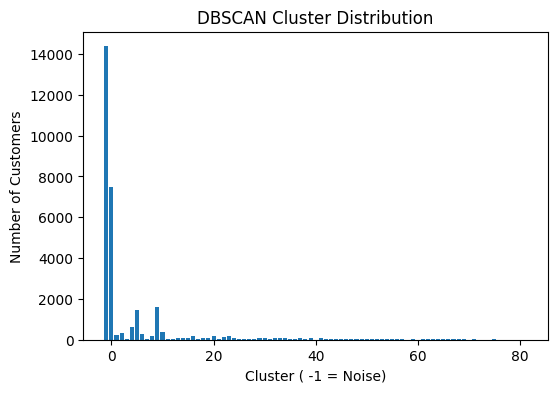

In [ ]:
# 5. CLUSTERING - DBSCAN

print("=== DBSCAN CLUSTERING ===")
# Try different DBSCAN parameters to find good clustering
dbscan = DBSCAN(eps=0.8, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to dataframe
df['DBSCAN_Cluster'] = labels_dbscan

unique_clusters = np.unique(labels_dbscan)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"DBSCAN clustering completed")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Cluster distribution: {np.bincount(labels_dbscan + 1)}")  # +1 to handle noise (-1)

# Visualize DBSCAN results
plt.figure(figsize=(6, 4))
dbscan_counts = pd.Series(labels_dbscan).value_counts().sort_index()
plt.bar(dbscan_counts.index, dbscan_counts.values)
plt.xlabel('Cluster ( -1 = Noise)')
plt.ylabel('Number of Customers')
plt.title('DBSCAN Cluster Distribution')
plt.show()

In [ ]:
# 6. CLUSTERING EVALUATION

print("=== CLUSTERING EVALUATION ===")

# KMeans evaluation
kmeans_silhouette = silhouette_score(X_scaled, labels_kmeans)
kmeans_dbi = davies_bouldin_score(X_scaled, labels_kmeans)

print(f"KMeans - Silhouette Score: {kmeans_silhouette:.4f}")
print(f"KMeans - Davies-Bouldin Index: {kmeans_dbi:.4f}")

# DBSCAN evaluation (only if we have more than 1 cluster)
if len(np.unique(labels_dbscan)) > 1 and n_clusters > 0:
    # For DBSCAN, we need to remove noise points for metric calculation
    non_noise_mask = labels_dbscan != -1
    if sum(non_noise_mask) > 1 and len(np.unique(labels_dbscan[non_noise_mask])) > 1:
        dbscan_silhouette = silhouette_score(X_scaled[non_noise_mask], labels_dbscan[non_noise_mask])
        dbscan_dbi = davies_bouldin_score(X_scaled[non_noise_mask], labels_dbscan[non_noise_mask])
        print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"DBSCAN - Davies-Bouldin Index: {dbscan_dbi:.4f}")
    else:
        print("DBSCAN - Cannot calculate metrics (not enough non-noise points or clusters)")
        dbscan_silhouette = -1
        dbscan_dbi = float('inf')
else:
    print("DBSCAN - Cannot calculate metrics (only one cluster found)")
    dbscan_silhouette = -1
    dbscan_dbi = float('inf')

=== CLUSTERING EVALUATION ===
KMeans - Silhouette Score: 0.2479
KMeans - Davies-Bouldin Index: 1.6843
DBSCAN - Silhouette Score: -0.1482
DBSCAN - Davies-Bouldin Index: 1.5123


=== 2D VISUALIZATION WITH PCA ===


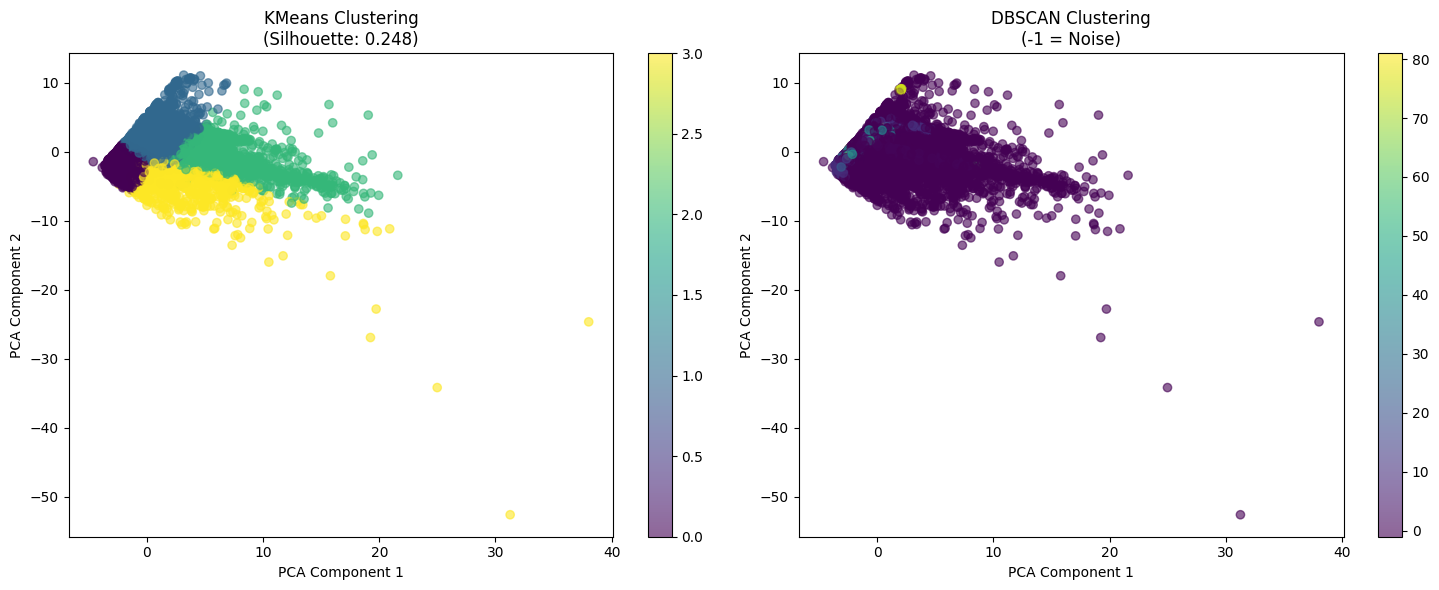

PCA explained variance ratio: [0.34403886 0.19612091]
Total variance explained: 0.540


In [ ]:
# 7. VISUALIZATION (2D PCA)

print("=== 2D VISUALIZATION WITH PCA ===")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 6))

# KMeans visualization
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f'KMeans Clustering\n(Silhouette: {kmeans_silhouette:.3f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# DBSCAN visualization
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('DBSCAN Clustering\n(-1 = Noise)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

=== CLUSTER PROFILING ===
KMeans Cluster Profiles (mean values):
                LIMIT_BAL    AGE  BILL_AMT1  PAY_AMT1  AVG_BILL_AMT  \
KMeans_Cluster                                                        
0               215854.98  36.26    8565.43   3985.56       6088.17   
1               101084.85  34.54   46203.97   3478.55      39397.64   
2               270134.36  37.00  211473.02   9971.90     188576.45   
3               336360.79  36.81   74709.79  44621.94      90514.37   

                UTILIZATION_RATIO  
KMeans_Cluster                     
0                            0.06  
1                            0.60  
2                            0.83  
3                            0.25  


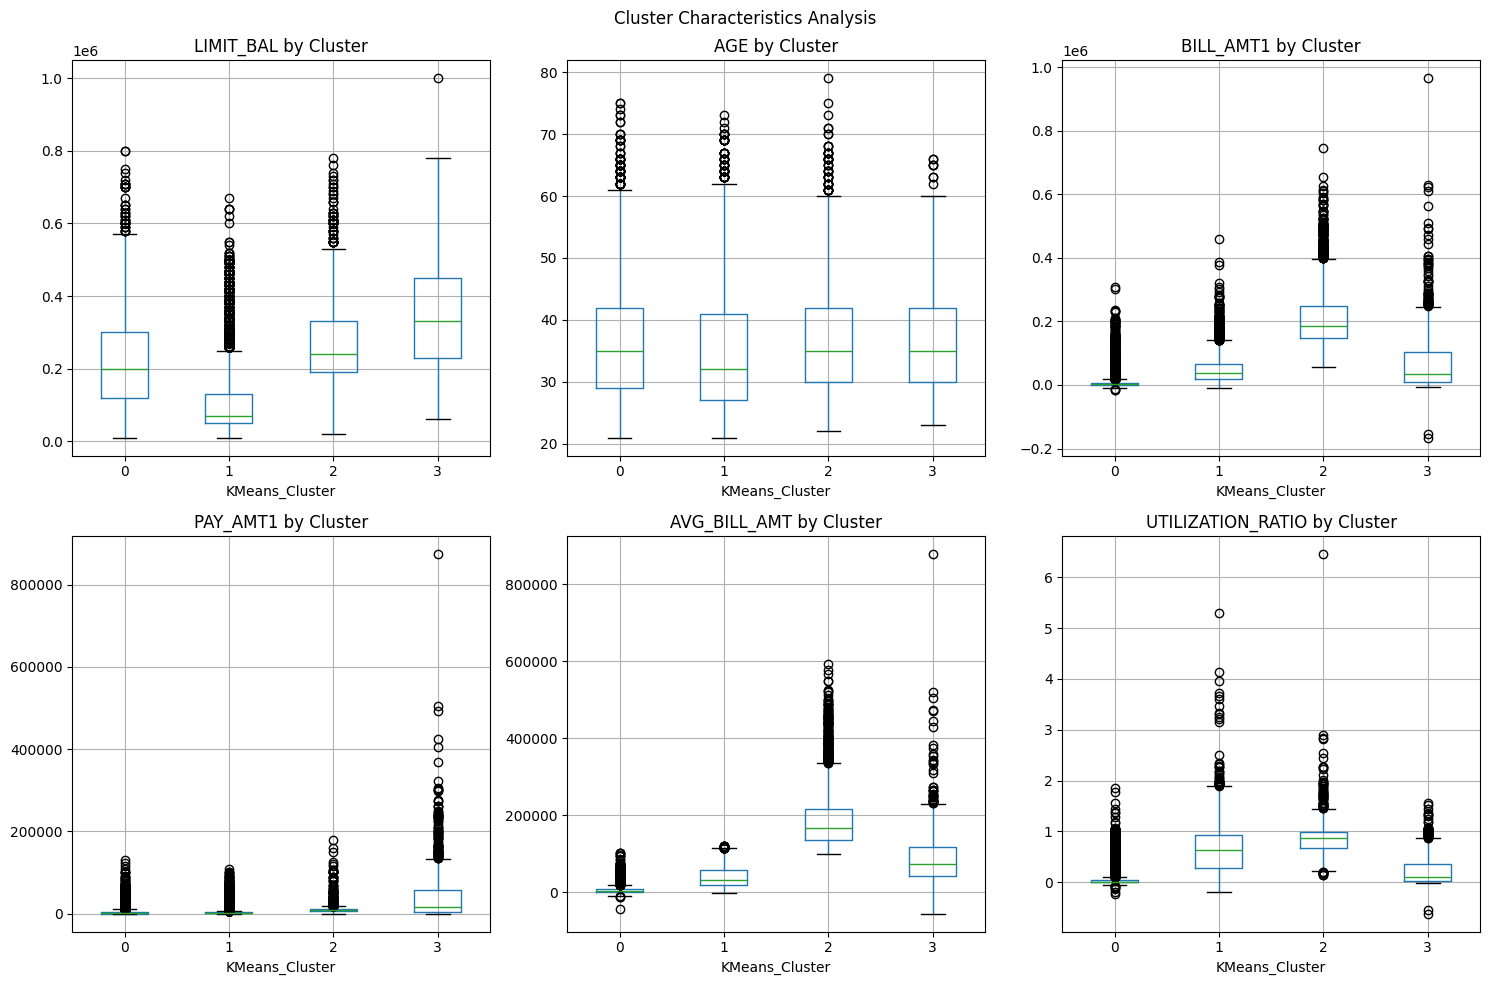

In [ ]:
# 8. CLUSTER ANALYSIS - Understanding what each cluster represents

print("=== CLUSTER PROFILING ===")

# Analyze KMeans clusters
cluster_profile = df.groupby('KMeans_Cluster')[['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1', 'AVG_BILL_AMT', 'UTILIZATION_RATIO']].mean()
print("KMeans Cluster Profiles (mean values):")
print(cluster_profile.round(2))

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features_to_plot = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1', 'AVG_BILL_AMT', 'UTILIZATION_RATIO']

for i, feature in enumerate(features_to_plot):
    row, col = i // 3, i % 3
    df.boxplot(column=feature, by='KMeans_Cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Cluster')

plt.suptitle('Cluster Characteristics Analysis')
plt.tight_layout()
plt.show()

In [ ]:
# 9. APPROXIMATE NEAREST NEIGHBOR (ANN) WITH ANNOY

print("=== APPROXIMATE NEAREST NEIGHBOR (ANN) ===")

# Build Annoy index
dim = X_scaled.shape[1]
annoy_index = AnnoyIndex(dim, 'euclidean')

# Add all items to the index
for i in range(len(X_scaled)):
    annoy_index.add_item(i, X_scaled[i])

# Build the index
annoy_index.build(10)  # 10 trees
print("Annoy index built successfully!")

# Select 4 random query points from different clusters
query_indices = []
for cluster in np.unique(labels_kmeans):
    cluster_indices = np.where(labels_kmeans == cluster)[0]
    query_indices.append(np.random.choice(cluster_indices))

print(f"Selected query indices (one from each cluster): {query_indices}")

# Find nearest neighbors for each query point
for query_idx in query_indices:
    print(f"\n--- Query Point {query_idx} (Cluster {labels_kmeans[query_idx]}) ---")

    # Find 6 nearest neighbors (including the point itself)
    neighbors, distances = annoy_index.get_nns_by_item(query_idx, 6, include_distances=True)

    # Remove the query point itself (first neighbor)
    neighbors = neighbors[1:]
    distances = distances[1:]

    print("Nearest Neighbors:")
    for i, (neighbor, distance) in enumerate(zip(neighbors, distances)):
        print(f"  {i+1}. Index: {neighbor} | Distance: {distance:.4f} | Cluster: {labels_kmeans[neighbor]}")

    # Check if neighbors are in same cluster
    same_cluster_count = sum(1 for n in neighbors if labels_kmeans[n] == labels_kmeans[query_idx])
    print(f"Neighbors in same cluster: {same_cluster_count}/{len(neighbors)}")

=== APPROXIMATE NEAREST NEIGHBOR (ANN) ===
Annoy index built successfully!
Selected query indices (one from each cluster): [np.int64(27265), np.int64(2080), np.int64(19886), np.int64(13911)]

--- Query Point 27265 (Cluster 0) ---
Nearest Neighbors:
  1. Index: 16327 | Distance: 0.1397 | Cluster: 0
  2. Index: 9554 | Distance: 0.2346 | Cluster: 0
  3. Index: 26545 | Distance: 0.2530 | Cluster: 0
  4. Index: 24792 | Distance: 0.2612 | Cluster: 0
  5. Index: 29134 | Distance: 0.2664 | Cluster: 0
Neighbors in same cluster: 5/5

--- Query Point 2080 (Cluster 1) ---
Nearest Neighbors:
  1. Index: 3202 | Distance: 0.1763 | Cluster: 1
  2. Index: 17800 | Distance: 0.2273 | Cluster: 1
  3. Index: 27642 | Distance: 0.2304 | Cluster: 1
  4. Index: 17016 | Distance: 0.2361 | Cluster: 1
  5. Index: 5153 | Distance: 0.2391 | Cluster: 1
Neighbors in same cluster: 5/5

--- Query Point 19886 (Cluster 2) ---
Nearest Neighbors:
  1. Index: 15904 | Distance: 2.5554 | Cluster: 2
  2. Index: 24222 | Distanc